In [1]:
import csv 
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
samples = []
datafile = '../data/'

with open(datafile + 'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)

    for line in reader:
        samples.append(line)
samples.pop(0)

['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

In [3]:
from sklearn.model_selection import train_test_split
import sklearn
import random

train_samples, validation_samples = train_test_split(samples, test_size=0.2)



corrections = [0, 0.25, -0.25]
def generator(samples, batch_size=256):
    num_samples = len(samples)
    
    while True:
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            weights = []
            
            for batch_sample in batch_samples:
                for i in range(3):
                    name = datafile + './IMG/' + batch_sample[i].split('/')[-1]
                    img = cv2.imread(name)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
                    angle = float(batch_sample[3])
                    weights.append(.01 + abs(angle))
                    weights.append(.01 + abs(angle))
                    images.append(img)
                    angles.append(angle)
                    images.append(np.fliplr(img))
                    angles.append(-angle)


            yield (np.array(images), np.array(angles), np.array(weights))

In [4]:
train_generator = generator(train_samples)
validation_generator = generator(validation_samples)


In [5]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, BatchNormalization, Dropout, ELU
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [6]:
model = Sequential()

model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x/127.5 - 1.0))

model.add(Convolution2D(24,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
model.add(Convolution2D(36,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
model.add(Convolution2D(48,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
model.add(Convolution2D(64,3,3,border_mode='valid', activation='relu', subsample=(1,1)))
model.add(Convolution2D(64,3,3,border_mode='valid', activation='relu', subsample=(1,1)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='tanh'))

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 90, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 43, 158, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

Epoch 1/3
38568/38568 [==============================] - 73s - loss: 0.0044 - val_loss: 0.0042
Epoch 2/3
38568/38568 [==============================] - 62s - loss: 0.0030 - val_loss: 0.0032
Epoch 3/3
38568/38568 [==============================] - 63s - loss: 0.0025 - val_loss: 0.0019


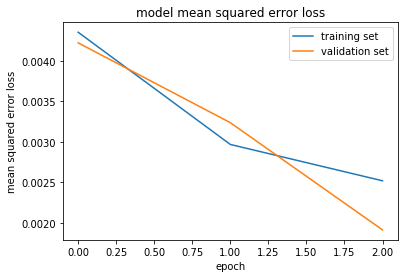

In [7]:
epochs = 3

model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator, validation_data=validation_generator, samples_per_epoch=len(train_samples)*6, nb_val_samples=len(validation_samples)*6, nb_epoch=epochs, verbose=1)

model.save('modelv3.h5')

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()